##Data

In [0]:
pip install textdistance

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from itertools import product
import textdistance
from xgboost import XGBRegressor
from xgboost import plot_importance
from datetime import datetime, date
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/sales_train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/test.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/sample_submission.csv')
items = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/items.csv')
item_categories = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/item_categories.csv')
shops = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/shops.csv')

In [0]:
item_categories_english_list = ['PC - Headsets / Headphones','Accessories - PS2','Accessories - PS3',
                                'Accessories - PS4','Accessories - PSP','Accessories - PSVita',
                                'Accessories - XBOX 360','Accessories - XBOX ONE','Tickets (digits)',
                                'Delivery of goods','Game consoles - PS2','Game consoles - PS3',
                                'Game consoles - PS4','Game consoles - PSP','Game consoles - PSVita',
                                'Game consoles - XBOX 360','Game consoles - XBOX ONE',
                                'Game consoles - Other','Games - PS2','Games - PS3','Games - PS4',
                                'Games - PSP','Games - PSVita','Games - XBOX 360','Games - XBOX ONE',
                                'Games - Accessories for games','Games Android - Digital',
                                'Games MAC - Digital','Games PC - Additional publications',
                                "Games PC - Collector's Edition",'Games PC - Standard Edition',
                                'Games PC - Digital','Payment card (Movies, Music, Games)',
                                'Payment cards - Live!','Payment cards - Live! (Numeral)',
                                'Payment cards - PSN','Payment card - Windows (figure)',
                                'Movies - Blu-Ray','The Movie - Blu-Ray 3D','Cinema - Blu-Ray 4K',
                                'Movies - DVD','Cinema - Collector','Books - artbook, encyclopedia',
                                'Books - Audiobooks','Books - Audiobooks (figure)',
                                'Books - Audiobooks 1C','Books - Business Books','Books - Comics, Manga',
                                'Books - Computer Books','Books - Methodical materials 1C',
                                'Books - Postcards','Books - Informative literature','Books - Guides',
                                'Books - Fiction','Books - Digital','Music - CD of local production',
                                'Music - CD production firm','Music - MP3','Music - Vinyl',
                                'Music - Music video','Music - Gift Edition','Gifts - Attributes',
                                'Gifts - gadgets, robots, sports','Gifts - Soft Toys',
                                'Gifts - Board Games','Gifts - Games (compact)','Gifts - Cards, Stickers',
                                'Gifts - Development','Gifts - certificates, services',
                                'Gifts - Souvenirs','Gifts - Souvenirs (weighed in)',
                                'Gifts - Bags, Albums, Mats d / mouse','Gifts - Figures',
                                'Program - 1C: Enterprise 8','Program - MAC (figure)',
                                'Program - For home and office','Program - Home & Office (Digital)',
                                'Program - Educational','Programs - Educational (figure)','System Tools',
                                'Utilities - Tickets','Net carriers (spire)','Net carriers (piece)',
                                'batteries']

##Create Category and Sub category

In [0]:
len(item_categories_english_list)
english_category = []
english_sub_category = []
for i in item_categories_english_list:
  new_i = i.split(" - ")
  english_category.append(new_i[0])
  if(len(new_i))>1:
    english_sub_category.append(new_i[1])
  else:
    english_sub_category.append(new_i[0])

In [0]:
#create english main and sub category
item_categories["big_category_name"] = english_category
item_categories["sub_category_name"] = english_sub_category
item_categories["big_category_id"] = item_categories.big_category_name.astype("category").cat.codes.to_frame(name = "big_category_id")
item_categories["sub_category_id"] = item_categories.sub_category_name.astype("category").cat.codes.to_frame(name = "sub_category_id")

##cleaning exceptional data

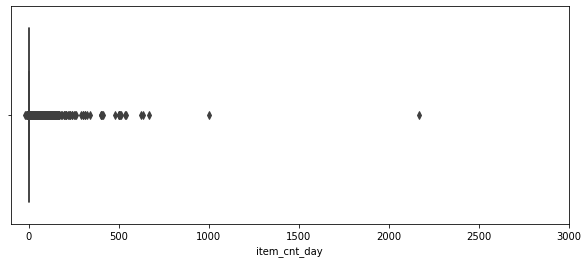

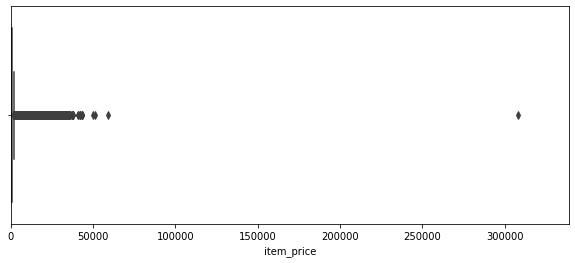

In [0]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [0]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [0]:
# check duplicated rows
print(train.duplicated().count())

# delete duplicated rows
train = train[~train.duplicated()]

2935847


##Visualize data 
Using plots and info

In [0]:
# show train info
print("-----------------train-------------------------")
train.info()
print(train.head())
print(train.describe())

-----------------train-------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935841 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935841e+06  2.935841e+06  2.935841e+06  2.935841e+06  2.935841e+06
mean     1.456991e+01  3.30

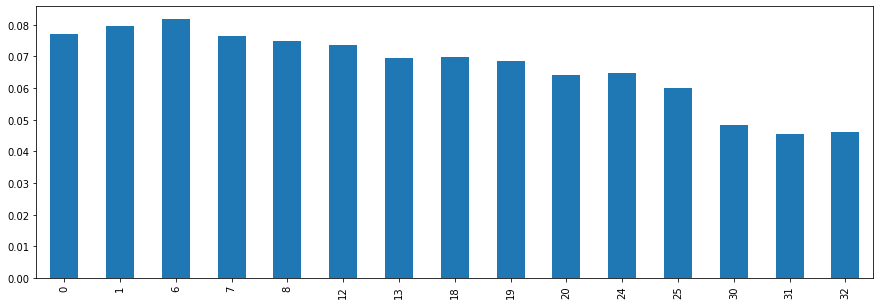

In [0]:
#plot date_block_num - sales of each month ( 11 and 23 have a large number of sales)

train["date_block_num"].value_counts(normalize=True).sort_index().plot(kind="bar", figsize = (15,5))


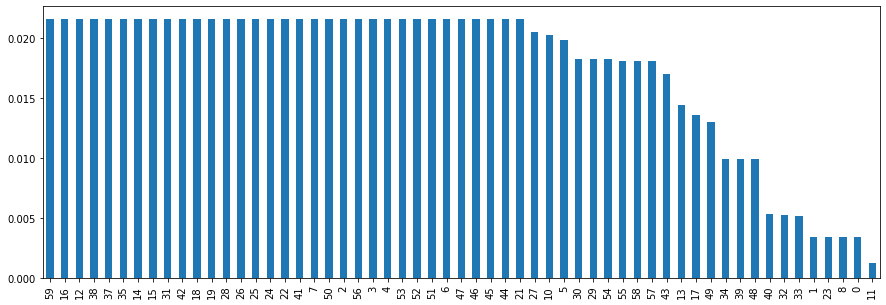

In [0]:
#shop_id -sales by shop (Some shops have a large number of sales)  

train["shop_id"].value_counts(normalize=True).plot(kind="bar", figsize = (15,5))



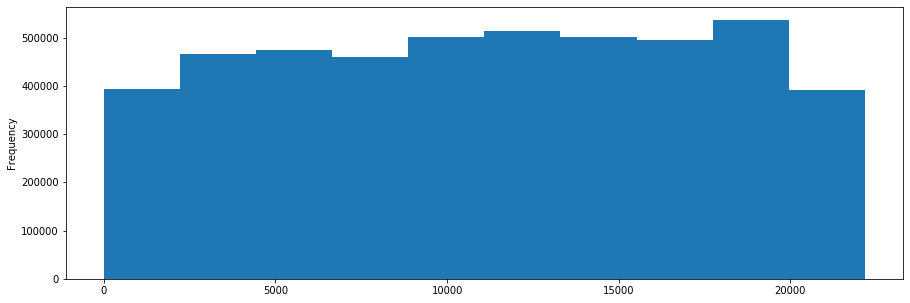

In [0]:
# sales per item (The distribution is not even. Some items seem to have more sales than others.)
train["item_id"].plot(kind="hist", figsize = (15,5))


In [0]:
#first 10 items (id,count of sales)
train["item_id"].value_counts().sort_values(ascending=False)[:10]

4694     695
15450    695
19778    695
4602     695
11379    695
17064    695
5275     695
12967    695
8690     695
11377    695
Name: item_id, dtype: int64

In [0]:
#first 10 shops (id,count of items)
train["shop_id"].value_counts().sort_values(ascending=False)[:10]

47    102033
6     102033
52    102033
53    102033
4     102033
3     102033
56    102033
2     102033
50    102033
7     102033
Name: shop_id, dtype: int64

In [0]:
#print item 1 info from items
items.loc[items["item_id"]==1]

,item_name,item_id,item_category_id
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [0]:
#plot item_category_id 1 from item_categories
item_categories.loc[item_categories["item_category_id"]==1]

,item_category_name,item_category_id,big_category_name,sub_category_name,big_category_id,sub_category_id
1,Аксессуары - PS2,1,Accessories,PS2,0,44


We can see that sales not equivalent , Maybe it is substituted by another item or chaged its price.


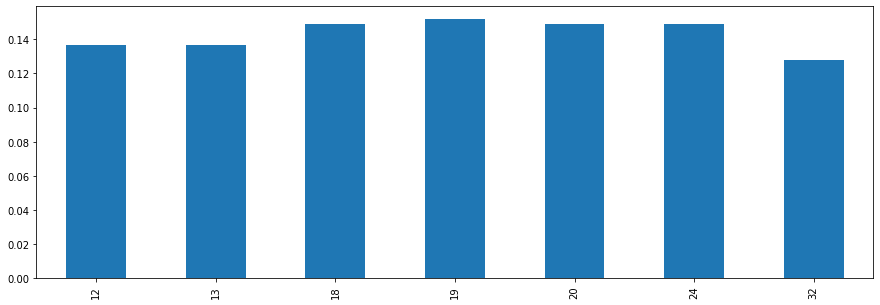

In [0]:
#plot item_id 2000 for each month that it apper
train.loc[train["item_id"]==2000]["date_block_num"].value_counts(normalize=True).sort_index().plot(kind="bar", figsize = (15,5))
print("We can see that sales not equivalent , Maybe it is substituted by another item or chaged its price.")

##Preprocessing

**Train set extension**:
Compute item_cnt_days of all combinations of shop and item across date_block_num.
If there is not item_cnt_days for a given combination of shop and item a given date_block_num, item_cnt_days as 0 is computed.

In [0]:
train_extended = []
for i in range(34):
    sales = train.query('date_block_num == @i')
    train_extended.append(np.array(list(product([i] ,sales["shop_id"].unique(), sales["item_id"].unique()))))

cols = ["date_block_num", "shop_id", "item_id"]
train_extended = pd.DataFrame(np.vstack(train_extended), columns = cols)
train_extended

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913799,33,21,7635
10913800,33,21,7638
10913801,33,21,7640
10913802,33,21,7632


**Creating item_cnt_month columns**


In [0]:
train_monthly = train.groupby(['date_block_num', "shop_id", "item_id"], as_index = False)\
    .agg({"item_cnt_day" : ["sum"]})
train_monthly.columns = ['date_block_num',"shop_id", "item_id", "item_cnt_month"]

# train_monthly_max = train.groupby(['date_block_num', "shop_id", "item_id"], as_index = False)\
#     .agg({"item_cnt_day" : ["max"]})
# train_monthly_max.columns = ['date_block_num',"shop_id", "item_id","max_price"]

# train_monthly["max_price"] = train_monthly_max["max_price"]

# train_monthly_min = train.groupby(['date_block_num', "shop_id", "item_id"], as_index = False)\
#     .agg({"item_cnt_day" : ["min"]})
# train_monthly_min.columns = ['date_block_num',"shop_id", "item_id","min_price"]

# train_monthly["min_price"] = train_monthly_min["min_price"]

train_monthly_mean = train.groupby(['date_block_num', "shop_id", "item_id"], as_index = False)\
    .agg({"item_cnt_day" : ["mean"]})
train_monthly_mean.columns = ['date_block_num',"shop_id", "item_id","avg_price"]

train_monthly["avg_price"] = train_monthly_mean["avg_price"]


# train_monthly["diff_price"] = train_monthly["max_price"] - train_monthly["min_price"]

train_monthly

,date_block_num,shop_id,item_id,item_cnt_month,avg_price
0,0,0,32,6.0,1.5
1,0,0,33,3.0,1.0
2,0,0,35,1.0,1.0
3,0,0,43,1.0,1.0
4,0,0,51,2.0,1.0
...,...,...,...,...,...
1609118,33,59,22087,6.0,2.0
1609119,33,59,22088,2.0,1.0
1609120,33,59,22091,1.0,1.0
1609121,33,59,22100,1.0,1.0


In [0]:
# marge all the possible combination of item and shop and add the item_cnt_month that culc before
# if there is no item_cnt_month value for tuple insert 0
train_new = train_extended.merge(train_monthly, on=["date_block_num", "shop_id", "item_id"], how="left").fillna(0)

In [0]:
#insert new month number for prediction
test = test.drop("ID", axis = 1)
test.insert(0, "date_block_num", 34)

In [0]:
#add test to train ( not sure if it right )
train_new = pd.concat([train_new, test], ignore_index=True, sort=False, keys=["date_block_num", "shop_id", "item_id", "item_cnt_month"])
train_new.fillna(0, inplace=True)

In [0]:
# Adding month number to each month
train_new["month_number"] = [(int(i)+1)%12 for i in train_new["date_block_num"]]

In [0]:
import math
train_new["year"] = train_new['date_block_num'].apply(lambda x:((math.floor(x//12)+2013))-2013)

In [0]:
# Add holidays by number of holiday days each month

# holidays_by_months = {1:6,2:1,3:1,5:5,7:1,11:2}
# train_new["holiday_month"] = [holidays_by_months[int(i)] if int(i) in holidays_by_months else 0 for i in train_new["month_number"]]

holidays_by_months = {1:1,2:1,3:1,5:1,7:1,11:1}
train_new["holiday_month"] = [holidays_by_months[int(i)] if int(i) in holidays_by_months else 0 for i in train_new["month_number"]]

In [0]:
train_new

,date_block_num,shop_id,item_id,item_cnt_month,avg_price,month_number,year,holiday_month
0,0,59,22154,1.0,1.0,1,0,1
1,0,59,2552,0.0,0.0,1,0,1
2,0,59,2554,0.0,0.0,1,0,1
3,0,59,2555,0.0,0.0,1,0,1
4,0,59,2564,0.0,0.0,1,0,1
...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,0.0,11,2,1
11128000,34,45,16188,0.0,0.0,11,2,1
11128001,34,45,15757,0.0,0.0,11,2,1
11128002,34,45,19648,0.0,0.0,11,2,1


**Create train data**

In [0]:
items_and_item_categories = items.drop(columns=["item_name"]).merge(item_categories.drop(columns=["item_category_name", "big_category_name", "sub_category_name"]))
items_and_item_categories

,item_id,item_category_id,big_category_id,sub_category_id
0,0,40,10,20
1,2,40,10,20
2,3,40,10,20
3,4,40,10,20
4,5,40,10,20
...,...,...,...,...
22165,22095,83,24,64
22166,22096,83,24,64
22167,22097,83,24,64
22168,22098,83,24,64


In [0]:
train_new = train_new.merge(items_and_item_categories, on = ["item_id"])
test = test.merge(items_and_item_categories, on = ["item_id"])

In [0]:
train_new = train_new.merge(shops.drop(columns=["shop_name"]), on = ["shop_id"])
test = test.merge(shops.drop(columns=["shop_name"]), on = ["shop_id"])

In [0]:
train_new.fillna(0, inplace=True)
test.fillna(0, inplace=True)
train_new

,date_block_num,shop_id,item_id,item_cnt_month,avg_price,month_number,year,holiday_month,item_category_id,big_category_id,sub_category_id
0,0,59,22154,1.0,1.0,1,0,1,37,10,8
1,1,59,22154,0.0,0.0,2,0,1,37,10,8
2,2,59,22154,0.0,0.0,3,0,1,37,10,8
3,3,59,22154,0.0,0.0,4,0,0,37,10,8
4,7,59,22154,0.0,0.0,8,0,0,37,10,8
...,...,...,...,...,...,...,...,...,...,...,...
11127999,25,11,8805,0.0,0.0,2,2,1,40,10,20
11128000,25,11,7623,0.0,0.0,2,2,1,64,9,11
11128001,25,11,20797,0.0,0.0,2,2,1,72,9,27
11128002,25,11,20907,0.0,0.0,2,2,1,72,9,27


In [0]:
train_new.sort_values(by=['date_block_num'])

,date_block_num,shop_id,item_id,item_cnt_month,avg_price,month_number,year,holiday_month,item_category_id,big_category_id,sub_category_id
0,0,59,22154,1.0,1.0,1,0,1,37,10,8
4355297,0,10,3204,0.0,0.0,1,0,1,30,8,55
4355299,0,10,3209,1.0,1.0,1,0,1,30,8,55
4355306,0,10,3210,1.0,1.0,1,0,1,30,8,55
4355314,0,10,3214,0.0,0.0,1,0,1,30,8,55
...,...,...,...,...,...,...,...,...,...,...,...
10747588,34,48,20999,0.0,0.0,11,2,1,61,9,3
10747580,34,48,21010,0.0,0.0,11,2,1,61,9,3
10747577,34,48,20343,0.0,0.0,11,2,1,72,9,27
10747570,34,48,12332,0.0,0.0,11,2,1,40,10,20


**Test data**


In [0]:
test_sort = pd.read_csv('/content/drive/My Drive/Colab Notebooks/למידה עמוקה - 2/test.csv')
test_sort.drop("ID", axis=1, inplace = True)

## Data Split

### %3

In [0]:
train = train_new.query('date_block_num % 3 !=0 | date_block_num ==0') # 1 - 30
val = train_new.query('date_block_num % 3 ==0 & date_block_num !=0') # 31 - 33
test = test_sort.merge(train_new.query('date_block_num == 34'), on = ["shop_id", "item_id"], how="left") # 34

### By close to target by month number
train = (month_number == 7 | month_number == 8 | month_number == 9 | month_number == 12 | month_number == 1 | month_number == 2).

val = ('month_number == 10 | month_number == 11')

In [0]:
train = train_new.query('month_number == 7 | month_number == 8 | month_number == 9 | month_number == 12 | month_number == 1 | month_number == 2')
val = train_new.query('month_number == 10 | month_number == 11') # 31 - 33
test = test_sort.merge(train_new.query('date_block_num == 34'), on = ["shop_id", "item_id"], how="left") # 34

### By close to target by month number
train = (month_number == 5 | month_number == 6 | month_number == 7 | month_number == 8 | month_number == 9 | month_number == 12).

val = ('month_number == 10 | month_number == 11')

In [0]:
train = train_new.query('month_number == 5 | month_number == 6 | month_number == 7 | month_number == 8 | month_number == 9 | month_number == 12')
val = train_new.query('month_number == 10 | month_number == 11') # 31 - 33
test = test_sort.merge(train_new.query('date_block_num == 34'), on = ["shop_id", "item_id"], how="left") # 34

### Split 

train - val - test


In [0]:
train = train.sort_values(by='month_number', ascending=True)
val = val.sort_values(by='month_number', ascending=True)
test = test.sort_values(by='month_number', ascending=True)

train = train.drop(["month_number","year"],axis=1)
val = val.drop(["month_number","year"],axis=1)
test = test.drop(["month_number","year"],axis=1)

In [0]:
X_train = train.drop("item_cnt_month", axis = 1).reset_index(drop=True)
X_val = val.drop("item_cnt_month", axis = 1).reset_index(drop=True)
y_train = train[["item_cnt_month"]].reset_index(drop=True)
y_val = val[["item_cnt_month"]].reset_index(drop=True)
X_test = test.drop("item_cnt_month", axis = 1).reset_index(drop=True)
y_train = y_train.to_numpy()
y_train= y_train.flatten()
# y_train.shape
# X_train.shape

##RandomForestRegressor

In [0]:
#was 50
rf_model = RandomForestRegressor(n_estimators=30, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test.fillna(0))

In [0]:
submission = pd.DataFrame(rf_test_pred, columns=["item_cnt_month"]).clip(0, 20).reset_index()
submission.columns = ["ID", "item_cnt_month"]
print(submission)
submission.to_csv("submissionRF.csv", index=False)

            ID  item_cnt_month
0            0             0.0
1            1             0.0
2            2             0.0
3            3             0.0
4            4             0.0
...        ...             ...
214195  214195             0.0
214196  214196             0.0
214197  214197             0.0
214198  214198             0.0
214199  214199             0.0

[214200 rows x 2 columns]


##Xgboost

In [0]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [0]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=200,
    min_child_weight=400, 
    colsample_bytree=0.6, 
    subsample=0.6, 
    eta=0.2,    
    seed=0,
    learning_rate = 0.1,
    n_jobs=-1)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=10, 
    early_stopping_rounds = 10)

In [0]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
X_test_gb = pd.DataFrame()
X_test_gb['date_block_num'] = X_test['date_block_num']
X_test_gb['shop_id'] = X_test['shop_id']
X_test_gb['item_id'] = X_test['item_id']
X_test_gb['avg_price'] = X_test['avg_price']
# X_test_gb['max_price'] = X_test['max_price']
# X_test_gb['min_price'] = X_test['min_price']
# X_test_gb['diff_price'] = X_test['diff_price']
# X_test_gb['month_number'] = X_test['month_number']
# X_test_gb['year'] = X_test['year']
X_test_gb['holiday_month'] = X_test['holiday_month']
X_test_gb['item_category_id'] = X_test['item_category_id']
X_test_gb['big_category_id'] = X_test['big_category_id']
X_test_gb['sub_category_id'] = X_test['sub_category_id']
xgb_test_pred = xgb_model.predict(X_test_gb)

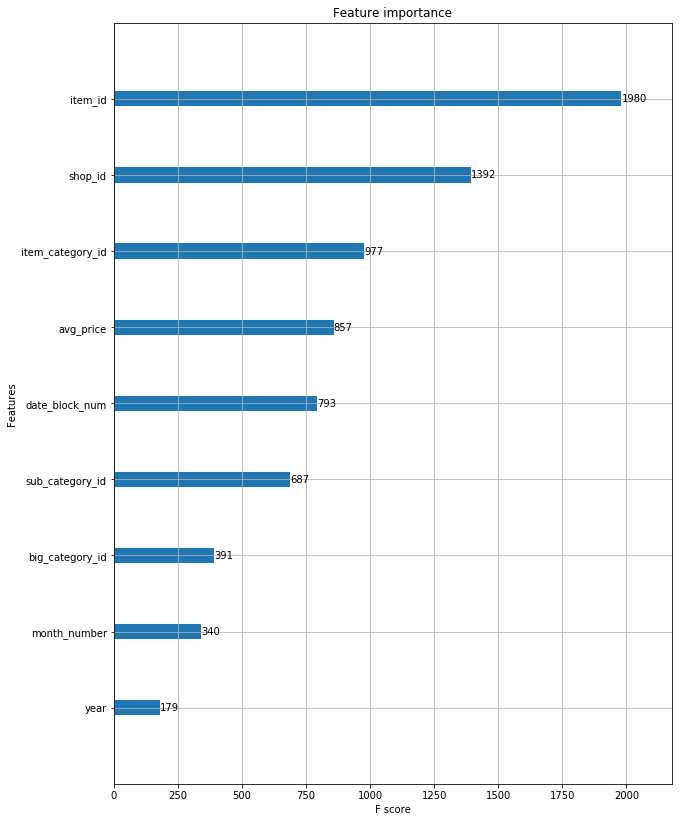

In [0]:
plot_features(xgb_model, (10,14))

In [0]:
submission = pd.DataFrame(xgb_test_pred, columns=["item_cnt_month"]).clip(0, 20).reset_index()
submission.columns = ["ID", "item_cnt_month"]
print(submission)

            ID  item_cnt_month
0            0        0.000000
1            1        0.010278
2            2        0.000000
3            3        0.000000
4            4        0.000000
...        ...             ...
214195  214195        0.000000
214196  214196        0.000000
214197  214197        0.000000
214198  214198        0.618388
214199  214199        0.000000

[214200 rows x 2 columns]


In [0]:
submission.to_csv("submissionLxgb.csv", index=False)

##Linear regression - Mix RF and Xgb

In [0]:
first_level = pd.DataFrame(xgb_val_pred, columns=["xgb"])
first_level["rf"] = rf_val_pred
first_level.info()

first_level_test = pd.DataFrame(xgb_test_pred, columns=["xgb"])
first_level_test["rf"] = rf_test_pred
first_level_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831639 entries, 0 to 1831638
Data columns (total 2 columns):
xgb    float32
rf     float64
dtypes: float32(1), float64(1)
memory usage: 21.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
xgb    214200 non-null float32
rf     214200 non-null float64
dtypes: float32(1), float64(1)
memory usage: 2.5 MB


In [0]:
meta_model = LinearRegression(n_jobs=-1)
meta_model.fit(first_level, y_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [0]:
test_prediction = meta_model.predict(first_level_test)

###submission


In [0]:
submissionLR = pd.DataFrame(test_prediction, columns=["item_cnt_month"]).clip(0, 20).reset_index()
submissionLR.columns = ["ID", "item_cnt_month"]
print(submissionLR)

            ID  item_cnt_month
0            0        0.415451
1            1        0.222925
2            2        0.361775
3            3        0.348390
4            4        0.822086
...        ...             ...
214195  214195        0.218773
214196  214196        0.230980
214197  214197        0.221486
214198  214198        0.221159
214199  214199        0.225714

[214200 rows x 2 columns]


In [0]:
submissionLR.to_csv("submissionLR.csv", index=False)

##Rnn

In [0]:
# importing libraries required for our model
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,Dropout,Flatten,CuDNNLSTM,Bidirectional,Embedding,RepeatVector,Input,concatenate,Reshape,Concatenate
from keras.losses import mean_squared_error
from keras import regularizers

Using TensorFlow backend.


In [0]:
!pip list | grep tensorflow

mesh-tensorflow          0.1.7      
tensorflow               1.15.0     
tensorflow-datasets      1.3.2      
tensorflow-estimator     1.15.1     
tensorflow-gan           2.0.0      
tensorflow-hub           0.7.0      
tensorflow-metadata      0.15.1     
tensorflow-privacy       0.2.2      
tensorflow-probability   0.7.0      


In [0]:
# # ------------- first lstm---------------
# model_lstm = Sequential()
# model_lstm.add(Embedding(200, 128, input_length=6))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(CuDNNLSTM(128))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(128))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])
# print(model_lstm.summary())

In [0]:
#-----second try---------------
# model_lstm = Sequential()
# model_lstm.add(Embedding(200, 128, input_length=6))
# model_lstm.add(CuDNNLSTM(128))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])
# print(model_lstm.summary())

In [0]:
# # ------------- 3rd lstm---------------
# model_lstm = Sequential()
# model_lstm.add(Embedding(300, 128, input_length=6))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(CuDNNLSTM(128))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(128))
# model_lstm.add(Dense(64))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])
# print(model_lstm.summary())

In [0]:
# # ------------- 4rd lstm---------------
# model_lstm = Sequential()
# model_lstm.add(Embedding(300, 256, input_length=6))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(CuDNNLSTM(256))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(128))
# model_lstm.add(Dense(64))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])
# print(model_lstm.summary())

In [0]:
# # # ------------- 7rd lstm---------------
# model_lstm = Sequential()
# model_lstm.add(Embedding(300, 256, input_length=7))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(CuDNNLSTM(128))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])
# print(model_lstm.summary())

In [0]:
# # # ------------- 8rd lstm---------------
# model_lstm = Sequential()
# model_lstm.add(Embedding(300, 128, input_length=8))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(CuDNNLSTM(128))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])
# print(model_lstm.summary())

In [0]:
# # ------------- 9rd lstm---------------
def create_model():
  model_lstm = Sequential()
  model_lstm.add(Embedding(300, 128, input_length=10))
  model_lstm.add(Dropout(0.4))
  model_lstm.add(Bidirectional(CuDNNLSTM(128,return_sequences=True)))
  model_lstm.add(Dropout(0.4))
  model_lstm.add(Bidirectional(CuDNNLSTM(128)))
  # model_lstm.add(Attention(128))
  model_lstm.add(Dropout(0.4))
  model_lstm.add(Dense(64))
  model_lstm.add(Dense(1))
  return model_lstm
  

In [0]:
def PrintHistoryModel(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.title('Model train and val')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['mean_absolute_error'])
  plt.plot(history.history['val_mean_absolute_error'])
  plt.title('Model loss')
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

## My model

In [0]:

import math
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)

In [0]:
model = create_model() 
model.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error","mae"])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 128)           38400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 256)           264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               395264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)              

In [0]:
train.query('date_block_num == 5')

,date_block_num,shop_id,item_id,item_cnt_month,avg_price,month_number,year,holiday_month,item_category_id,big_category_id,sub_category_id
8534954,5,44,3823,0.0,0.0,6,0,0,55,11,13
8534939,5,44,3873,0.0,0.0,6,0,0,29,8,17
8535212,5,44,3280,0.0,0.0,6,0,0,55,11,13
8534922,5,44,3788,0.0,0.0,6,0,0,55,11,13
8534916,5,44,3852,0.0,0.0,6,0,0,19,5,45
...,...,...,...,...,...,...,...,...,...,...,...
10134396,5,55,17222,0.0,0.0,6,0,0,55,11,13
10134942,5,55,16874,0.0,0.0,6,0,0,37,10,8
10134961,5,55,16877,0.0,0.0,6,0,0,40,10,20
10134972,5,55,16878,0.0,0.0,6,0,0,40,10,20


In [0]:
hist = model.fit(X_train,y_train,batch_size = 1024,epochs = 8,callbacks=[lrate],validation_data=(X_val,y_val))

Train on 3743391 samples, validate on 3652271 samples
Epoch 1/8
3743391/3743391 [==============================] - 94s 25us/step - loss: 6.3930 - mean_squared_error: 6.3930 - mean_absolute_error: 0.4269 - val_loss: 6.9868 - val_mean_squared_error: 6.9868 - val_mean_absolute_error: 0.3058
Epoch 2/8
3743391/3743391 [==============================] - 94s 25us/step - loss: 4.4163 - mean_squared_error: 4.4163 - mean_absolute_error: 0.3334 - val_loss: 6.4281 - val_mean_squared_error: 6.4281 - val_mean_absolute_error: 0.2361
Epoch 3/8
3743391/3743391 [==============================] - 94s 25us/step - loss: 3.6082 - mean_squared_error: 3.6082 - mean_absolute_error: 0.2854 - val_loss: 5.5621 - val_mean_squared_error: 5.5621 - val_mean_absolute_error: 0.2777
Epoch 4/8
3743391/3743391 [==============================] - 94s 25us/step - loss: 2.9234 - mean_squared_error: 2.9234 - mean_absolute_error: 0.2632 - val_loss: 5.9700 - val_mean_squared_error: 5.9700 - val_mean_absolute_error: 0.2294
Epoch 

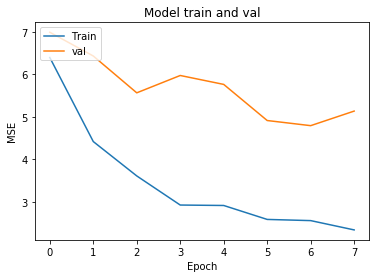

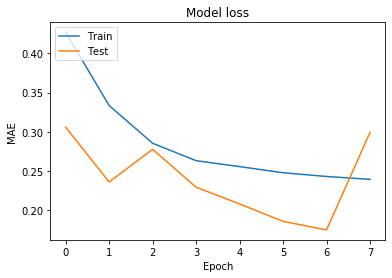

None


In [0]:
print(PrintHistoryModel(hist))

Submission



In [0]:
# creating submission file
submission_pfs = model.predict(X_test)
ids = [x for x in range(len(submission_pfs))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = submission_pfs
submission_df.to_csv('submissionLSTM.csv',index = False)

### feature extraction

In [0]:
model2 = Model(input=model.input, output=model.get_layer(model.layers[3].name).output)
X_train_features = model2.predict(X_train)
X_test_features = model2.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("em..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


LinearRegression

In [0]:
#was 50
rf_model = LinearRegression()
rf_model.fit(X_train_features, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Submission



In [0]:
# creating submission file
submission_pfs = rf_model.predict(X_test_features)
ids = [x for x in range(len(submission_pfs))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = submission_pfs
submission_df.to_csv('submissionLSTM_extract_to_LR.csv',index = False)

##Remove item_cnt_month = 0

In [0]:
train = train_new.query('date_block_num % 3 !=0 | date_block_num ==0') 
val = train_new.query('date_block_num % 3 ==0 & date_block_num !=0') 

train = train_new.query('item_cnt_month != 0') 
val = train_new.query('item_cnt_month != 0') 

test = test_sort.merge(train_new.query('date_block_num == 34'), on = ["shop_id", "item_id"], how="left") 

In [0]:
X_train = train.drop("item_cnt_month", axis = 1).reset_index(drop=True)
y_train = train[["item_cnt_month"]].reset_index(drop=True)
X_val = val.drop("item_cnt_month", axis = 1).reset_index(drop=True)
y_val = val[["item_cnt_month"]].reset_index(drop=True)
X_test = test.drop("item_cnt_month", axis = 1).reset_index(drop=True)
y_train = y_train.to_numpy()
y_train= y_train.flatten()
# y_train.shape
X_train.shape

(1606540, 8)

In [0]:
X_train = X_train[:30000]
y_train = y_train[:30000]
X_val = X_val[:2000]
y_val = y_val[:2000]

**RF**


In [0]:
#was 50
def RF(train,y_train):
  rf_model = RandomForestRegressor(n_estimators=30, max_depth=7, random_state=0, n_jobs=-1)
  rf_model.fit(train, y_train)
  return rf_model

In [0]:
RF_SIMPLE =RF(X_train,y_train)

In [0]:
rf_train_pred = RF_SIMPLE.predict(X_train)
rf_val_pred = RF_SIMPLE.predict(X_val)
rf_test_pred = RF_SIMPLE.predict(X_test)

In [0]:
# creating submission file
submission_pfs = rf_test_pred
ids = [x for x in range(len(submission_pfs))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = submission_pfs
submission_df.to_csv('submissionRF_LOW.csv',index = False)

**LSTM**

In [0]:
model_low = create_model() 
model_low.compile(optimizer="adam", loss=mean_squared_error, metrics=["mean_squared_error"])

In [0]:
print(model_low.summary())

In [0]:
model_low.fit(X_train,y_train,batch_size = 64,epochs = 10,validation_data=(X_val,y_val))

### Submission



In [0]:
# creating submission file
submission_pfs = model_low.predict(X_test)
ids = [x for x in range(len(submission_pfs))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = submission_pfs
submission_df.to_csv('submissionLSTM.csv',index = False)

In [0]:
model_low.layers[3].name

'dense_28'

In [0]:
extraction_model = Model(input=model_low.input, output=model_low.get_layer(model_low.layers[3].name).output)

features = []
for sample in X_train.iterrows(): 
 features.append(extraction_model.predict(np.expand_dims(sample[1], axis=0)))

test_features = []
for test_sample in X_test.iterrows(): 
 test_features.append(extraction_model.predict(np.expand_dims(test_sample[1], axis=0)))

train = np.squeeze(np.asarray(features))
test = np.squeeze(np.asarray(test_features))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("em..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [0]:
RF_embedding =RF(train,y_train)
classical_model_results=RF_embedding.predict(test)

In [0]:
# creating submission file
submission_pfs = rf_test_pred
ids = [x for x in range(len(submission_pfs))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = submission_pfs
submission_df.to_csv('submissionRF_embedding.csv',index = False)

## Concatenate

In [0]:
# importing libraries required for our model
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,Dropout,Flatten,CuDNNLSTM,Bidirectional,Embedding,RepeatVector,Input,concatenate,Reshape,Concatenate
from keras.losses import mean_squared_error
from keras import regularizers
from keras.regularizers import l2
from keras.optimizers import Adam


Using TensorFlow backend.


In [0]:
inp1 = Input(shape=(1,), dtype='int64', name='date_block_num')
em1 = Embedding(max(train_new.date_block_num)+1, 33, input_length=1, embeddings_regularizer=l2(1e-4))(inp1)
inp2 = Input(shape=(1,), dtype='int64', name='shop_id')
em2 = Embedding(max(train_new.shop_id)+1, 10, input_length=1, embeddings_regularizer=l2(1e-4))(inp2)
inp3 = Input(shape=(1,), dtype='int64', name='item_id')
em3 = Embedding(max(train_new.item_id)+1, 10, input_length=1, embeddings_regularizer=l2(1e-4))(inp3)
inp4 = Input(shape=(1,), dtype='int64', name='month_number')
em4 = Embedding(max(train_new.month_number)+1, 12, input_length=1, embeddings_regularizer=l2(1e-4))(inp4)
inp5 = Input(shape=(1,), dtype='int64', name='holiday_month')
em5 = Embedding(max(train_new.holiday_month)+1, 5, input_length=1, embeddings_regularizer=l2(1e-4))(inp5)
inp6 = Input(shape=(1,), dtype='int64', name='item_category_id')
em6 = Embedding(max(train_new.item_category_id)+1, 10, input_length=1, embeddings_regularizer=l2(1e-4))(inp6)
inp7 = Input(shape=(1,), dtype='int64', name='big_category_id')
em7 = Embedding(max(train_new.big_category_id)+1, 5, input_length=1, embeddings_regularizer=l2(1e-4))(inp7)
inp8 = Input(shape=(1,), dtype='int64', name='sub_category_id')
em8 = Embedding(max(train_new.sub_category_id)+1, 7, input_length=1, embeddings_regularizer=l2(1e-4))(inp8)

x = concatenate([em1,em2,em3,em4,em5,em6,em7,em8])
x = Flatten()(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
x = Dense(1)(x)
model_conc = Model([inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8],x)
model_conc.compile(Adam(0.001), loss='mse',metrics=["mean_squared_error","mean_absolute_error"])
model_conc_hist = model_conc.fit([X_train.date_block_num,X_train.shop_id,X_train.item_id,X_train.month_number,X_train.holiday_month,X_train.item_category_id,X_train.big_category_id,X_train.sub_category_id],y_train, batch_size=4096, epochs=20, 
          validation_data=([X_val.date_block_num,X_val.shop_id,X_val.item_id,X_val.month_number,X_val.holiday_month,X_val.item_category_id,X_val.big_category_id,X_val.sub_category_id], y_val))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 4730992 samples, validate on 1831639 samples
Epoch 1/20





4730992/4730992 [==============================] - 23s 5us/step - loss: 8.3319 - mean_squared_error: 8.3174 - mean_absolute_error: 0.4664 - val_loss: 9.6303 - val_mean_squared_error: 9.6079 - val_mean_absolute_error: 0.5004
Epoch 2/20
4730992/4730992 [==============================] - 13s 3us/step - loss: 7.3443 - mean_squared_error: 7.3183 - mean_absolute_error: 0.4542 - val_loss: 10.3265 - val_mean_squared_error: 10.2969 - val_mean_absolute_error: 0.5343
Epoch 3/20
4730992/4730992 [==============================] - 13s 3us/step - loss: 7.1170 - mean_squared_error: 7.0849 - mean_absolute_error: 0.4552 - val_loss: 9.1211 - val_mean_squared_error: 9.0867 - val_mean_absolute_error: 0.5731
Epoch 4/20
4730992/4730992 [==============================] - 14s 3us/step - loss: 6.6096 - mean_squared_error:

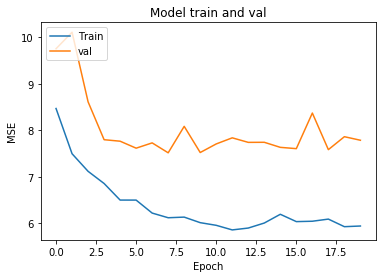

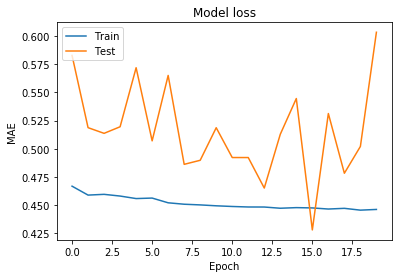

None


In [0]:
print(PrintHistoryModel(model_conc_hist))

In [0]:
# X_train_conc_feature = model_conc.predict([X_train[f] for f in ["date_block_num","shop_id","item_id","month_number","holiday_month","item_category_id","big_category_id","sub_category_id"]]).clip(0, 20)
Y_test_conc_feature = model_conc.predict([X_test[f] for f in ["date_block_num","shop_id","item_id","month_number","holiday_month","item_category_id","big_category_id","sub_category_id"]]).clip(0, 20)

Submission



In [0]:
# creating submission file
# submission_pfs = model.predict(X_test)
ids = [x for x in range(len(Y_test_conc_feature))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = Y_test_conc_feature
submission_df.to_csv('submissionConcat.csv',index = False)

In [0]:
model_conc.layers[21].name

'dense_26'

### Feature extraction

In [0]:
model3 = Model(input=model_conc.input, output=model_conc.get_layer(model_conc.layers[21].name).output)
X_train_conc_feature = model3.predict([X_train[f] for f in ["date_block_num","shop_id","item_id","month_number","holiday_month","item_category_id","big_category_id","sub_category_id"]]).clip(0, 20)
Y_test_conc_feature = model3.predict([X_test[f] for f in ["date_block_num","shop_id","item_id","month_number","holiday_month","item_category_id","big_category_id","sub_category_id"]]).clip(0, 20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


LinearRegression

In [0]:
#was 50
lr_model = LinearRegression()
lr_model.fit(X_train_conc_feature, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Submission



In [0]:
# creating submission file
submission_pfs = lr_model.predict(Y_test_conc_feature)
ids = [x for x in range(len(submission_pfs))]
submission_df = pd.DataFrame()
submission_df['ID'] = ids
submission_df['item_cnt_month'] = submission_pfs
submission_df.to_csv('submission_conct_extract_LR.csv',index = False)